## Imports & functions

In [1]:
# libraries
#%matplotlib notebook
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from janitor import groupby_agg

from datetime import datetime
from sklearn.pipeline import make_pipeline
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [2]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)


In [3]:
df = pd.read_csv(r'C:\Users\judit.gyorfi\OneDrive - Irdeto B.V\data for thesis\for modeling\clean_data.csv')
df.head()

,Unnamed: 0,sessionuserid,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
0,0,CAK.001:221036902,2020-03-20 02:00:00,1,1,1,1,3,12,4,80,2,1,1.0,1.0,1.0
1,1,CAK.001:221036902,2020-03-20 03:00:00,0,0,0,0,3,12,4,80,3,1,0.0,0.0,0.0
2,2,CAK.001:221036902,2020-03-20 04:00:00,0,0,0,0,3,12,4,80,4,1,0.0,0.0,0.0
3,3,CAK.001:221036902,2020-03-20 05:00:00,0,0,0,0,3,12,4,80,5,1,0.0,0.0,0.0
4,4,CAK.001:221036902,2020-03-20 06:00:00,0,0,0,0,3,12,4,80,6,1,0.0,0.0,0.0


###### top5 potentially most anomalious users: 
['CHARTER.8752:8752200300106696',
 'CAK.001:221036902',
 'MKE.004:063462105',
 'KYA.003:147067605',
 'CAR.202:917926801']

###### 3 normal users:
['NYC.8150:8150100042909977',
 'NYC.8150:8150100063661101',
 'TWC.999:900028101']

# Clustering - KMeans
- https://www.inovex.de/de/disadvantages-of-k-means-clustering/

Use for collective anomalies (unordered).
We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters. We use the following steps to find and visualize anomalies.

- Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
- We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.14 (14% of df are outliers as depicted above).
- Calculate number_of_outliers using outliers_fraction.
- Set threshold as the minimum distance of these outliers.
- The anomaly result of anomaly1 contains the above method Cluster (0:normal, 1:anomaly).
- Visualize anomalies with cluster view.
- Visualize anomalies with Time Series view.

In [4]:
customer_1 = df.loc[(df['sessionuserid'] == 'CHARTER.8752:8752200300106696')]
#customer_1 = customer_1.reset_index()
customer_1 = customer_1.set_index(customer_1['datetime'])
customer_1.head()

,Unnamed: 0,sessionuserid,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
datetime,,,,,,,,,,,,,,,,
2020-03-18 05:00:00,16679,CHARTER.8752:8752200300106696,2020-03-18 05:00:00,2,2,2,2,3,12,2,78,5,1,1.0,1.0,1.0
2020-03-18 06:00:00,16680,CHARTER.8752:8752200300106696,2020-03-18 06:00:00,0,0,0,0,3,12,2,78,6,1,0.0,0.0,0.0
2020-03-18 07:00:00,16681,CHARTER.8752:8752200300106696,2020-03-18 07:00:00,0,0,0,0,3,12,2,78,7,1,0.0,0.0,0.0
2020-03-18 08:00:00,16682,CHARTER.8752:8752200300106696,2020-03-18 08:00:00,0,0,0,0,3,12,2,78,8,1,0.0,0.0,0.0
2020-03-18 09:00:00,16683,CHARTER.8752:8752200300106696,2020-03-18 09:00:00,0,0,0,0,3,12,2,78,9,1,0.0,0.0,0.0


In [5]:
data = customer_1[['Num_Unique_ContentIDs',
                 'License_Count', 'Num_Unique_IPs','Num_Unique_DeviceIDs', 'Month', 'Week', 'DayOfTheWeek', 'DayOfTheYear','Hour', 'Weekday',
          'Ave_Num_LicenseCounts_Per_ContentID','Ave_Num_ContentIDs_Per_Device','Ave_Num_Devices_Per_Unique_Content']]

In [6]:
data

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
datetime,,,,,,,,,,,,,
2020-03-18 05:00:00,2,2,2,2,3,12,2,78,5,1,1.0,1.0,1.0
2020-03-18 06:00:00,0,0,0,0,3,12,2,78,6,1,0.0,0.0,0.0
2020-03-18 07:00:00,0,0,0,0,3,12,2,78,7,1,0.0,0.0,0.0
2020-03-18 08:00:00,0,0,0,0,3,12,2,78,8,1,0.0,0.0,0.0
2020-03-18 09:00:00,0,0,0,0,3,12,2,78,9,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 02:00:00,0,0,0,0,2,8,6,59,2,0,0.0,0.0,0.0
2021-02-28 03:00:00,0,0,0,0,2,8,6,59,3,0,0.0,0.0,0.0
2021-02-28 04:00:00,0,0,0,0,2,8,6,59,4,0,0.0,0.0,0.0


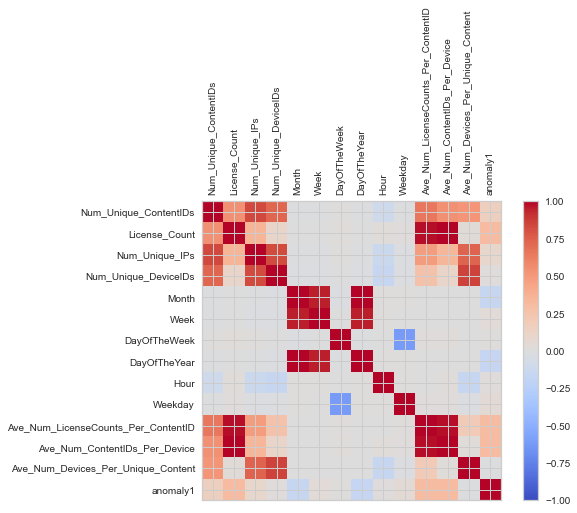

In [179]:
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [7]:
data_1 = data.copy()
data_2 = data.copy()
data_3 = data.copy()

#### The elbow method

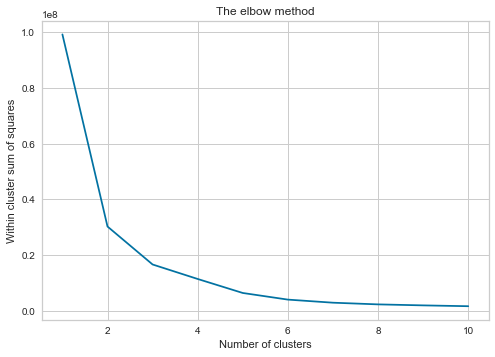

In [227]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()

### Clustering without preprocessing

In [281]:
x = data.iloc[:,:].values

#### Training

In [278]:
kmeans = KMeans(n_clusters=2,init = 'k-means++', random_state=42)
kmeans.fit(x)

KMeans(n_clusters=2, random_state=42)

In [279]:
principalDf = pd.DataFrame(data = x, columns = ['Num_Unique_ContentIDs', 'License_Count', 'Num_Unique_IPs',
       'Num_Unique_DeviceIDs', 'Month', 'Week', 'DayOfTheWeek', 'DayOfTheYear',
       'Hour', 'Weekday', 'Ave_Num_LicenseCounts_Per_ContentID',
       'Ave_Num_ContentIDs_Per_Device', 'Ave_Num_Devices_Per_Unique_Content'])

In [280]:
principalDf

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
0,2.0,2.0,2.0,2.0,3.0,12.0,2.0,78.0,5.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,3.0,12.0,2.0,78.0,6.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,12.0,2.0,78.0,7.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,12.0,2.0,78.0,8.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.0,12.0,2.0,78.0,9.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,0.0,0.0,0.0,0.0,2.0,8.0,6.0,59.0,2.0,0.0,0.0,0.0,0.0
8326,0.0,0.0,0.0,0.0,2.0,8.0,6.0,59.0,3.0,0.0,0.0,0.0,0.0
8327,0.0,0.0,0.0,0.0,2.0,8.0,6.0,59.0,4.0,0.0,0.0,0.0,0.0
8328,0.0,0.0,0.0,0.0,2.0,8.0,6.0,59.0,5.0,0.0,0.0,0.0,0.0


In [232]:
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

#### Visualizing the clusters
- Please adjust the plot with the features that you would like to examine. You can find the possible features 2 cells above.
- It might look like that there is only one centroid, but in reality those are 2 points really close to each other.
- When changing the features, the cluster center positions have to be modified on a 0-12 scale based on their order above.

https://colab.research.google.com/drive/1uYlxQguyJ4EvydQCN8RyLNs1F0zPC1wV#scrollTo=cjEfU6ZSMAPl

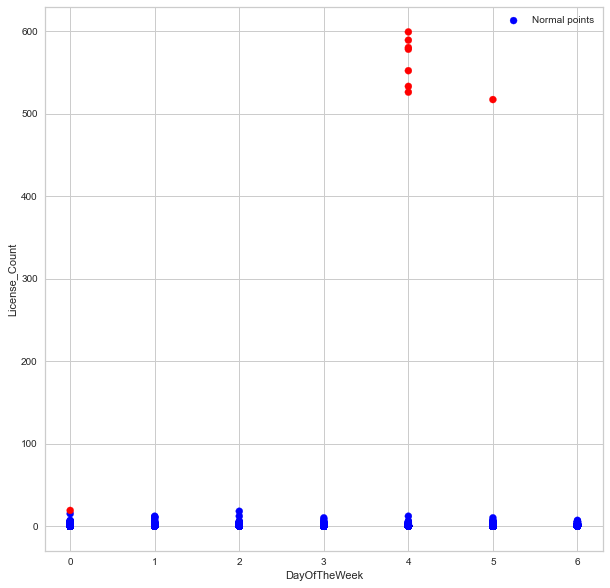

In [233]:
# visualisation of anomaly with cluster view
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(10,10))
plt.scatter(principalDf['DayOfTheWeek'],principalDf['License_Count'],c=principalDf["anomaly1"].apply(lambda x: colors[x]), label='Normal points')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'green', label = 'Centroids')
plt.ylabel('License_Count')
plt.xlabel('DayOfTheWeek')
plt.legend()
plt.show()

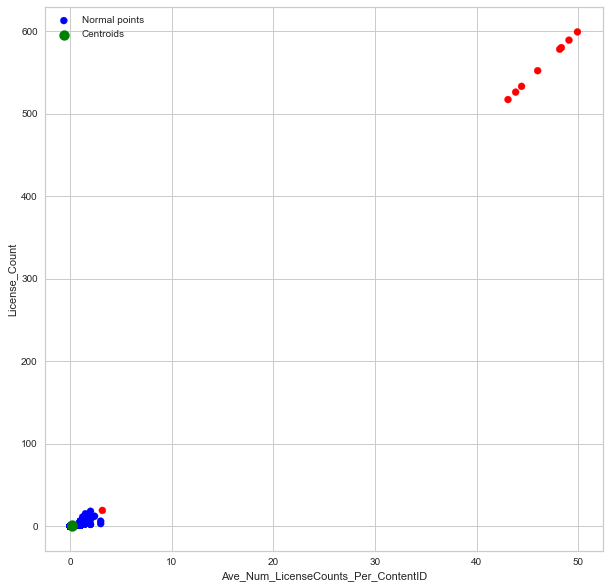

In [234]:
# visualisation of anomaly with cluster view
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(10,10))
plt.scatter(principalDf['Ave_Num_LicenseCounts_Per_ContentID'],principalDf['License_Count'],c=principalDf["anomaly1"].apply(lambda x: colors[x]), label='Normal points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'green', label = 'Centroids')
plt.ylabel('License_Count')
plt.xlabel('Ave_Num_LicenseCounts_Per_ContentID')
plt.legend()
plt.show()

<ipython-input-235-bda23dd3cbdd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=data.index)


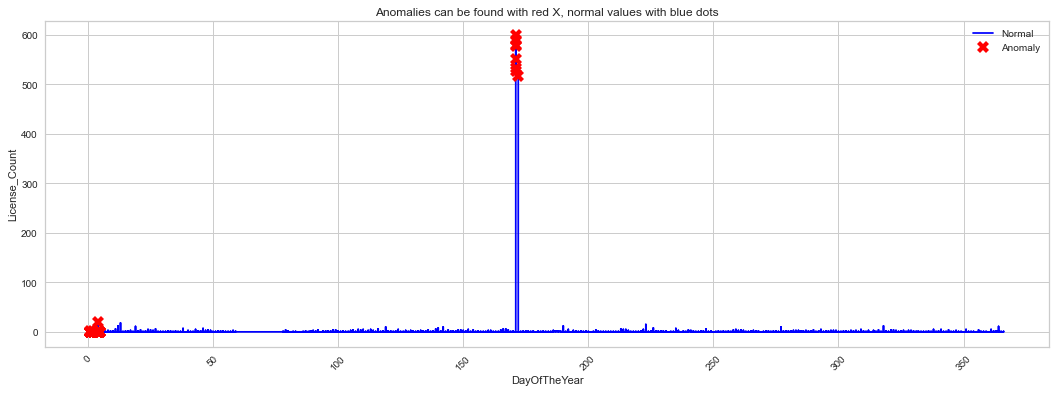

In [235]:
data['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=data.index)
a = data[data['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(data['DayOfTheYear'],data['License_Count'], color='blue', label='Normal')
_ = plt.plot(a['DayOfTheYear'],a['License_Count'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies can be found with red X, normal values with blue dots')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

In [75]:
print('With this method the model has found', len(a), 'anomalies within the dataset for this client.')

With this method the model has found 83 anomalies within the dataset for this client.


In [76]:
a.sort_values('License_Count',ascending=False)

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,anomaly1
datetime,,,,,,,,,,,,,,
2020-06-19 18:00:00,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2020-06-19 19:00:00,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2020-06-19 17:00:00,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2020-06-19 20:00:00,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2020-06-19 21:00:00,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 09:00:00,0,0,0,0,12,53,2,365,9,1,0.000000,0.0,0.000000,1
2020-12-30 10:00:00,0,0,0,0,12,53,2,365,10,1,0.000000,0.0,0.000000,1
2020-12-30 11:00:00,0,0,0,0,12,53,2,365,11,1,0.000000,0.0,0.000000,1


###### This plot shows only the data where the license count is less than 100.

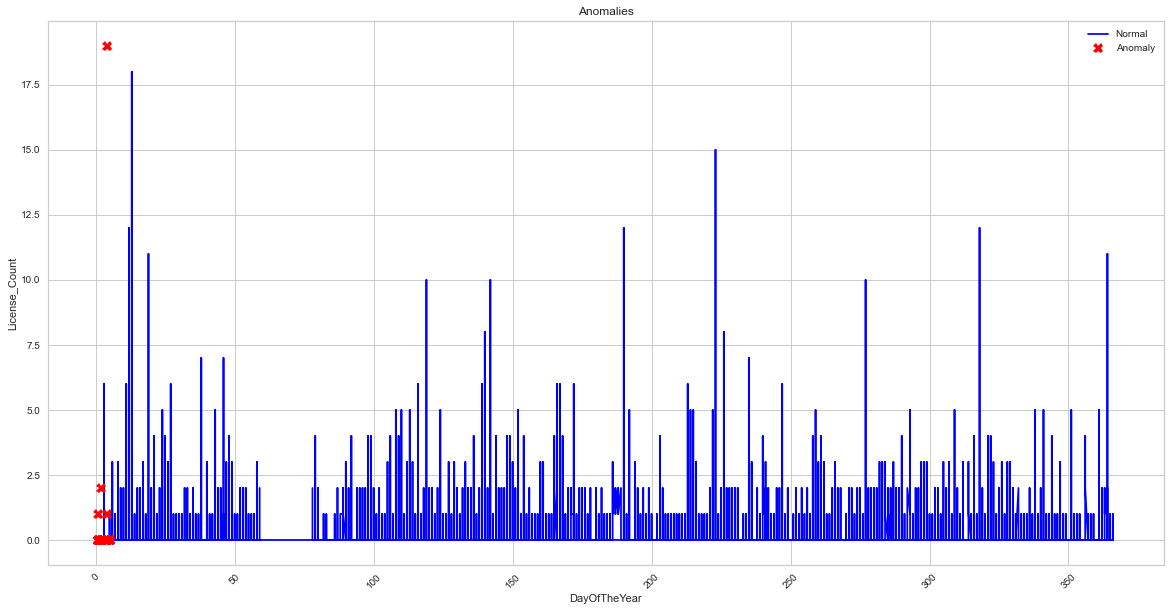

In [202]:
plottie = data[data['License_Count'] < 100]
a = plottie[plottie['anomaly1'] == 1] #anomaly
n = plottie[plottie['anomaly1'] == 0] #normality
_ = plt.figure(figsize=(20,10))
_ = plt.plot(n['DayOfTheYear'],n['License_Count'], color='blue',markersize=5, label='Normal')
_ = plt.plot(a['DayOfTheYear'], a['License_Count'], linestyle='None', marker='X', color='red', markersize=10, label='Anomaly')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

#### Evaluation

###### The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 
- Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [204]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)

    # define the model for K
    kmeans = KMeans(n_clusters = cluster,init = 'k-means++', random_state=42)
    kmeans.fit_transform(x)
    cluster_labels = kmeans.fit_predict(x)

    # pass the model through the visualizer
    #visualizer = SilhouetteVisualizer(kmeans)

    # fit the data
    #visualizer.fit(x)

    # show the chart
    #visualizer.poof()
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For cluster =", cluster,
          "The average silhouette_score is :", silhouette_avg)

----------------------------------------------------------------------------------------------------
For cluster = 2 The average silhouette_score is : 0.6029254543820165
----------------------------------------------------------------------------------------------------
For cluster = 3 The average silhouette_score is : 0.5577963952496501


In [240]:
del principalDf

NameError: name 'principalDf' is not defined

### Clustering with MinMaxScaler- keeping all the components

#### Preprocessing
- https://scikit-learn.org/stable/modules/preprocessing.html#
- Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
- PCA: a method that rotates the dataset in a way such that the rotated features are statistically uncorrelated.

In [43]:
z = data_1.iloc[:,:].values

In [44]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(z)

The goal of feature selection is to find the most effective
features that lead to training more accurate models and less computation time. Feature
selection techniques can be classified as filter, wrapper, embedded, and hybrid methods [25].
In the filter method, correlation criteria are employed widely in machine learning problems.
Correlation is a measure of the linear relationship between two or more parameters. In
feature selection, the most correlated features with the target would be chosen to build
the model. Moreover, those features should not show a high correlation with each other
to avoid using redundant data. 

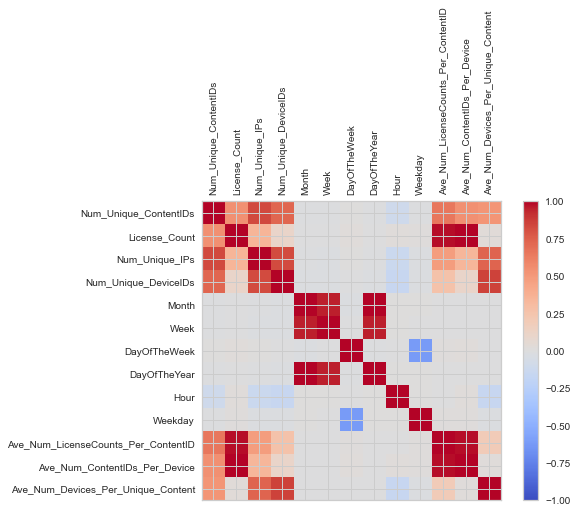

In [242]:
corr = data_1.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data_1.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data_1.columns)
ax.set_yticklabels(data_1.columns)
plt.show()

https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

In [92]:
x = data_1.iloc[:,[1,12]]
x = x.reset_index()
del x['datetime']

In [93]:
x.columns = ['x1','x2']
x

,x1,x2
0,2,1.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
8325,0,0.0
8326,0,0.0
8327,0,0.0
8328,0,0.0


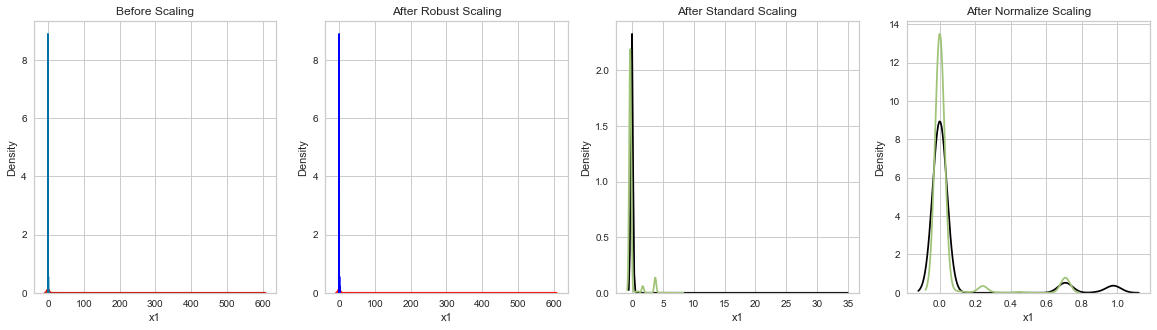

In [94]:
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['x1', 'x2'])
  
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['x1', 'x2'])
  
scaler = preprocessing.Normalizer()
normalize_df = scaler.fit_transform(x)
normalize_df = pd.DataFrame(normalize_df, columns =['x1', 'x2'])
  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling') 
sns.kdeplot(x['x1'], ax = ax1, color ='r')
sns.kdeplot(x['x2'], ax = ax1, color ='b')

ax2.set_title('After Robust Scaling')
sns.kdeplot(robust_df['x1'], ax = ax2, color ='red')
sns.kdeplot(robust_df['x2'], ax = ax2, color ='blue')

ax3.set_title('After Standard Scaling')
sns.kdeplot(standard_df['x1'], ax = ax3, color ='black')
sns.kdeplot(standard_df['x2'], ax = ax3, color ='g')

ax4.set_title('After Normalize Scaling')
sns.kdeplot(normalize_df['x1'], ax = ax4, color ='black')
sns.kdeplot(normalize_df['x2'], ax = ax4, color ='g')
plt.show()

#### Training

In [98]:
kmeans = KMeans(n_clusters=2,init = 'k-means++', random_state=42)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(data_1)
kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=42)

In [99]:
principalDf = pd.DataFrame(data = X_scaled, columns = ['Num_Unique_ContentIDs', 'License_Count', 'Num_Unique_IPs',
       'Num_Unique_DeviceIDs', 'Month', 'Week', 'DayOfTheWeek', 'DayOfTheYear',
       'Hour', 'Weekday', 'Ave_Num_LicenseCounts_Per_ContentID',
       'Ave_Num_ContentIDs_Per_Device', 'Ave_Num_Devices_Per_Unique_Content'])

In [100]:
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

#### Visualizing the clusters

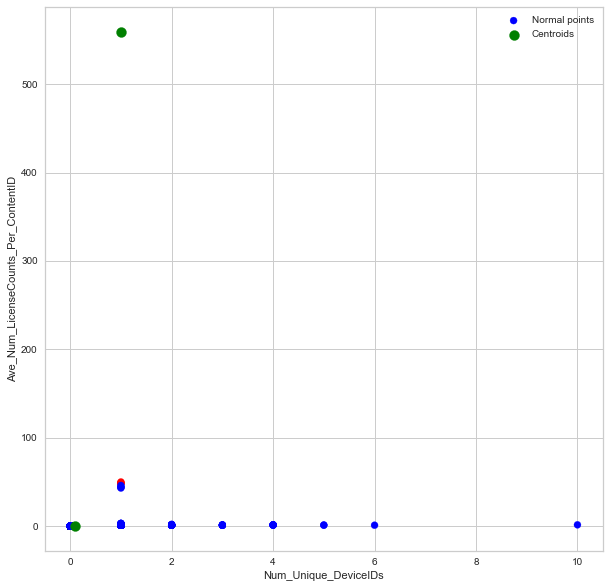

In [109]:
# visualisation of anomaly with cluster view
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(10,10))
plt.scatter(principalDf['Num_Unique_DeviceIDs'],principalDf['Ave_Num_LicenseCounts_Per_ContentID'],c=principalDf["anomaly1"].apply(lambda x: colors[x]), label='Normal points')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 1], s = 100, c = 'green', label = 'Centroids')
plt.ylabel('Ave_Num_LicenseCounts_Per_ContentID')
plt.xlabel('Num_Unique_DeviceIDs')
plt.legend()
plt.show()

In [106]:
kmeans.cluster_centers_

array([[ 1.62460947e-01,  1.78562845e-01,  1.09949531e-01,
         1.03580870e-01, -4.82055596e-02, -3.33669791e-02,
         1.95265561e-03, -1.83946719e-02,  4.19395910e-02,
        -1.42153329e-01,  9.85478346e-02,  1.68168709e-01,
         7.38837200e-02],
       [ 1.20000000e+01,  5.59250000e+02,  4.50000000e+00,
         1.00000000e+00, -1.66666667e-01, -1.60000000e-01,
         2.81250000e-01, -1.25718391e-01,  5.53191489e-01,
        -2.77555756e-17,  4.66041667e+01,  5.59250000e+02,
         8.33333333e-02]])

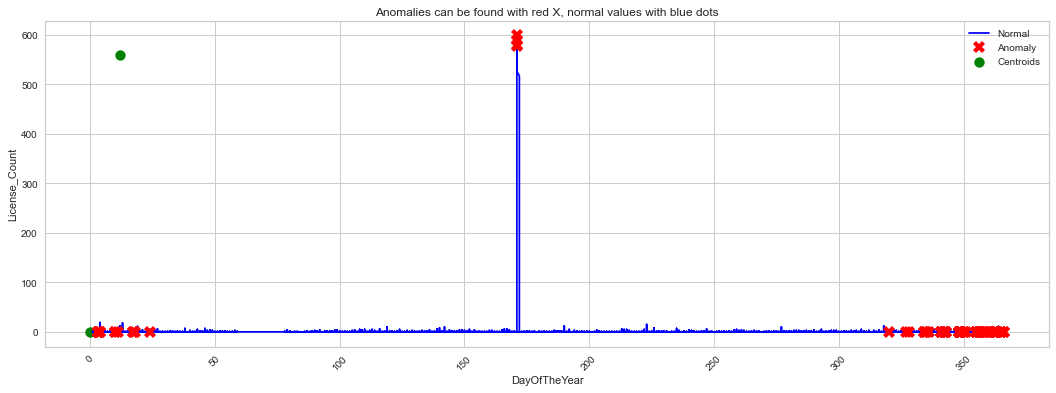

In [108]:
data_1['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=data_1.index)
a = data_1[data_1['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(data_1['DayOfTheYear'],data_1['License_Count'], color='blue', label='Normal')
_ = plt.plot(a['DayOfTheYear'],a['License_Count'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'green', label = 'Centroids')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies can be found with red X, normal values with blue dots')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show()

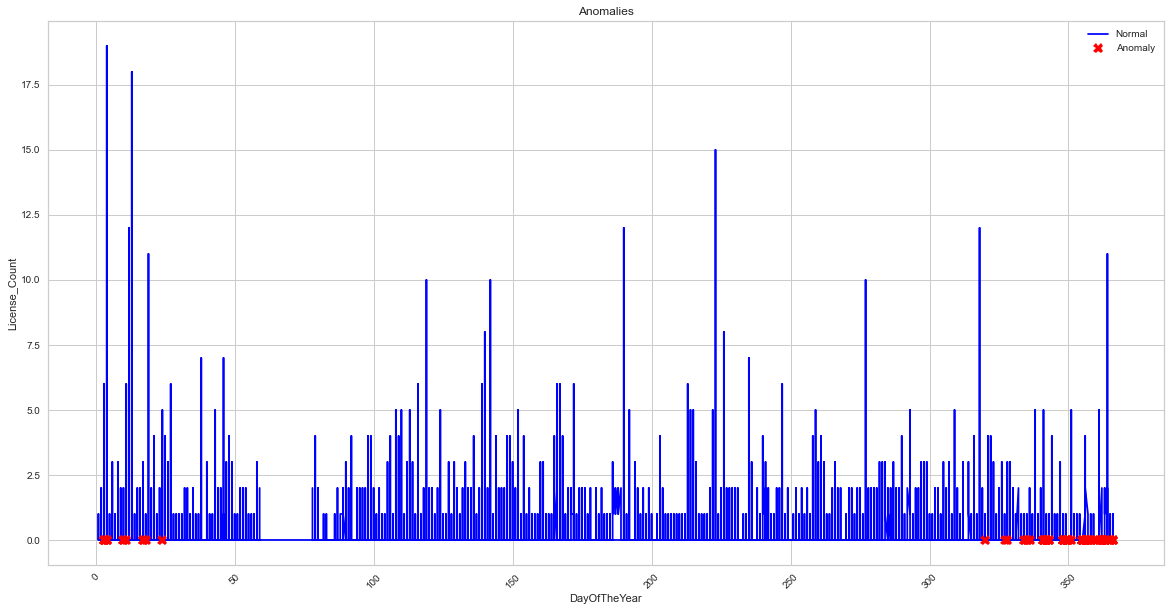

In [105]:
plottie = data_1[data_1['License_Count'] < 100]
a = plottie[plottie['anomaly1'] == 1] #anomaly
n = plottie[plottie['anomaly1'] == 0] #normality
_ = plt.figure(figsize=(20,10))
_ = plt.plot(n['DayOfTheYear'],n['License_Count'], color='blue',markersize=5, label='Normal')
_ = plt.plot(a['DayOfTheYear'], a['License_Count'], linestyle='None', marker='X', color='red', markersize=10, label='Anomaly')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

In [86]:
print('With this method the model has found', len(a), 'anomalies within the dataset for this client.')

With this method the model has found 83 anomalies within the dataset for this client.


In [103]:
a.sort_values('License_Count',ascending=False)

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,anomaly1
datetime,,,,,,,,,,,,,,
2020-06-19 18:00:00,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2020-06-19 19:00:00,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2020-06-19 17:00:00,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2020-06-19 20:00:00,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2020-12-27 00:00:00,0,0,0,0,12,52,6,362,0,0,0.000000,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14 00:00:00,0,0,0,0,12,51,0,349,0,1,0.000000,0.0,0.000000,1
2020-12-13 04:00:00,0,0,0,0,12,50,6,348,4,0,0.000000,0.0,0.000000,1
2020-12-13 03:00:00,0,0,0,0,12,50,6,348,3,0,0.000000,0.0,0.000000,1


#### Evaluation
- The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [15]:
# Results for 2 cluster:
#from sklearn.preprocessing import MinMaxScaler 0.29
#from sklearn.preprocessing import MaxAbsScaler 0.28
from sklearn.preprocessing import StandardScaler #0.93
from sklearn.preprocessing import RobustScaler #0.997
from sklearn.preprocessing import Normalizer #0.83
#from sklearn.preprocessing import QuantileTransformer 0.65
#from sklearn.preprocessing import PowerTransformer 0.67

In [30]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)

    # define the model for K
    kmeans = KMeans(n_clusters = cluster,init = 'k-means++', random_state=42)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(z)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # pass the model through the visualizer
    visualizer = SilhouetteVisualizer(kmeans)

    # fit the data
    #visualizer.fit(X_scaled)

    # show the chart
    #visualizer.poof()
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For cluster =", cluster,
          "The average silhouette_score is :", silhouette_avg)

----------------------------------------------------------------------------------------------------
For cluster = 2 The average silhouette_score is : 0.9971442935991209
----------------------------------------------------------------------------------------------------
For cluster = 3 The average silhouette_score is : 0.9967762549283565


In [254]:
del principalDf

### Clustering with PCA  & MinMaxScaler 
- keeping 2 components

#### Preprocessing

###### If PCA will be used more actively: https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

In [260]:
y = data_2.iloc[:,:].values

In [261]:
scaler = MinMaxScaler()
#pca = PCA(n_components=2)
pipeline = make_pipeline(scaler)
Y_scaled = pipeline.fit_transform(y)

##### The first two components explain 70% of the variance, which means that they contain over 70% of the information.

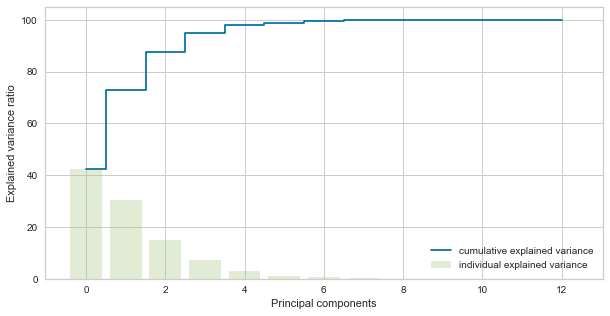

In [262]:
mean_vec = np.mean(Y_scaled, axis=0)
cov_mat = np.cov(Y_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [270]:
scaler = MinMaxScaler()
pca = PCA(n_components=2)
pipeline = make_pipeline(scaler, pca)
Y_scaled = pipeline.fit_transform(y)

#### Training

In [271]:
kmeans = KMeans(n_clusters=2,init = 'k-means++', random_state=42)
kmeans.fit(Y_scaled)

KMeans(n_clusters=2, random_state=42)

In [272]:
principalDf = pd.DataFrame(data = Y_scaled, columns = ['pc1', 'pc2'])

In [273]:
# Assume that X% of the entire data set are anomalies 
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest X% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

#### Visualising the clusters

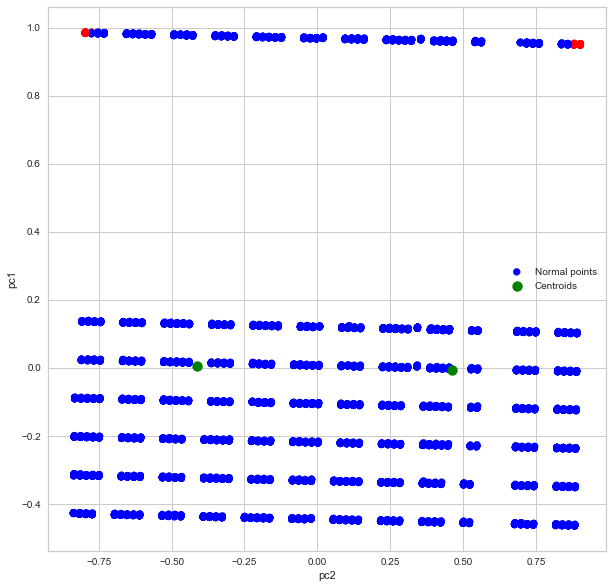

In [274]:
# visualisation of anomaly with cluster view
colors = {0:'blue', 1:'red'}
plt.figure(figsize=(10,10))
plt.scatter(principalDf['pc1'],principalDf['pc2'],c=principalDf["anomaly1"].apply(lambda x: colors[x]), label='Normal points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'green', label = 'Centroids')
plt.ylabel('pc1')
plt.xlabel('pc2')
plt.legend()
plt.show()

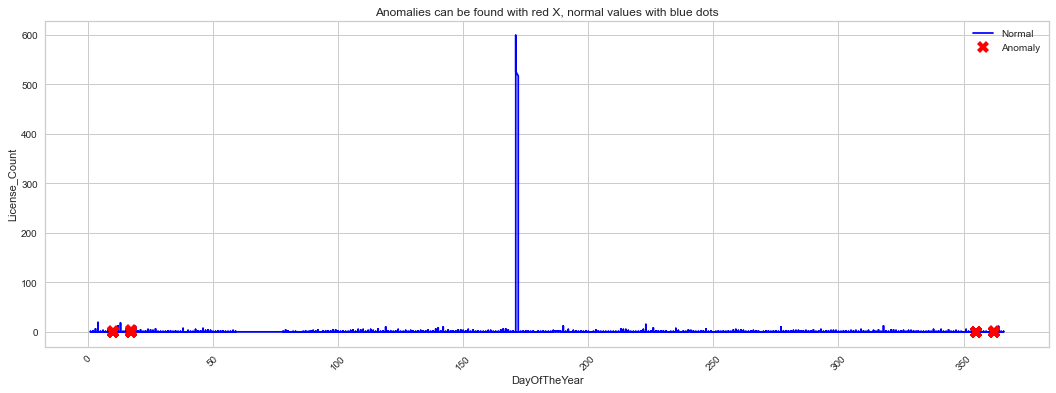

In [275]:
data_2['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=data_2.index)
a = data_2[data_2['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(data_2['DayOfTheYear'],data_2['License_Count'], color='blue', label='Normal')
_ = plt.plot(a['DayOfTheYear'],a['License_Count'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies can be found with red X, normal values with blue dots')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

In [97]:
print('With this method the model has found', len(a), 'anomalies within the dataset for this client.')

With this method the model has found 83 anomalies within the dataset for this client.


In [98]:
a.sort_values('License_Count',ascending=False)

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,anomaly1
datetime,,,,,,,,,,,,,,
2021-01-17 06:00:00,3,3,1,1,1,2,6,17,6,0,1.0,3.0,0.333333,1
2021-01-10 07:00:00,2,2,1,1,1,1,6,10,7,0,1.0,2.0,0.500000,1
2020-12-27 05:00:00,2,2,1,1,12,52,6,362,5,0,1.0,2.0,0.500000,1
2021-01-17 07:00:00,1,1,1,1,1,2,6,17,7,0,1.0,1.0,1.000000,1
2020-12-20 00:00:00,0,0,0,0,12,51,6,355,0,0,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 16:00:00,0,0,0,0,12,52,6,362,16,0,0.0,0.0,0.000000,1
2020-12-27 15:00:00,0,0,0,0,12,52,6,362,15,0,0.0,0.0,0.000000,1
2020-12-27 14:00:00,0,0,0,0,12,52,6,362,14,0,0.0,0.0,0.000000,1


#### Evaluation

In [276]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)

    # define the model for K
    kmeans = KMeans(n_clusters = cluster,init = 'k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(Y_scaled)

    # pass the model through the visualizer
    visualizer = SilhouetteVisualizer(kmeans)

    # fit the data
    #visualizer.fit(Y_scaled)

    # show the chart
    #visualizer.poof()
    silhouette_avg = silhouette_score(Y_scaled, cluster_labels)
    print("For cluster =", cluster,
          "The average silhouette_score is :", silhouette_avg)

----------------------------------------------------------------------------------------------------
For cluster = 2 The average silhouette_score is : 0.4156031588364094
----------------------------------------------------------------------------------------------------
For cluster = 3 The average silhouette_score is : 0.5175459353391556


In [100]:
del principalDf

# Isolation Forest

###### Very good model, numerical and categorical variables can be fed into it also, efficient, handles high dimensionality

###### This method isolates anomalies from normal instances, for doing this the following assumptions for anomalies are made:
- They are a minority consisting of fewer instances
- They have attribute-values that are different from normal instances
- In other words, anomalies are “few and different.”
- Because of these first two assumptions, anomalies are susceptible to be isolated and this makes them fall closer to the root of the tree.

In [101]:
df_if = df.loc[(df['sessionuserid'] == 'CHARTER.8752:8752200300106696')]
df_if = df_if.reset_index()
del df_if['Unnamed: 0']
del df_if['sessionuserid']
del df_if['index']
df_if.head()

,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
0,2020-03-18 05:00:00,2,2,2,2,3,12,2,78,5,1,1.0,1.0,1.0
1,2020-03-18 06:00:00,0,0,0,0,3,12,2,78,6,1,0.0,0.0,0.0
2,2020-03-18 07:00:00,0,0,0,0,3,12,2,78,7,1,0.0,0.0,0.0
3,2020-03-18 08:00:00,0,0,0,0,3,12,2,78,8,1,0.0,0.0,0.0
4,2020-03-18 09:00:00,0,0,0,0,3,12,2,78,9,1,0.0,0.0,0.0


In [102]:
del df_if['datetime']

In [103]:
data = df_if.copy()

In [104]:
data.head()

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
0,2,2,2,2,3,12,2,78,5,1,1.0,1.0,1.0
1,0,0,0,0,3,12,2,78,6,1,0.0,0.0,0.0
2,0,0,0,0,3,12,2,78,7,1,0.0,0.0,0.0
3,0,0,0,0,3,12,2,78,8,1,0.0,0.0,0.0
4,0,0,0,0,3,12,2,78,9,1,0.0,0.0,0.0


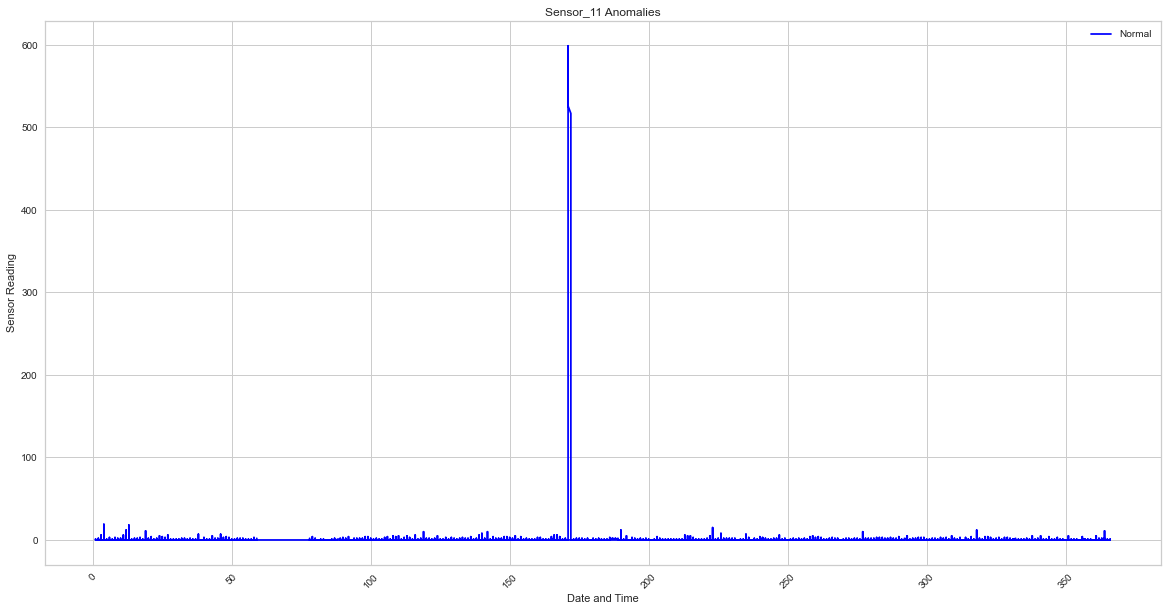

In [105]:
plottie = df_if[df_if['License_Count'] < 1000]
_ = plt.figure(figsize=(20,10))
_ = plt.plot(plottie['DayOfTheYear'],plottie['License_Count'], color='blue',markersize=10, label='Normal')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

### Only numerical data

In [106]:
# Let's assume 0,1% is anomalous
contamination = 0.001
# instantiate model
model = IsolationForest(contamination = contamination, n_estimators = 1000)
# fit model
y_iso = model.fit(data)

In [107]:
df_if['iforest'] = pd.Series(model.predict(data))
df_if['iforest'] = df_if['iforest'].map({1:0, -1:1})
print(df_if['iforest'].value_counts())

0    8321
1       9
Name: iforest, dtype: int64


#### Visualizing the clusters

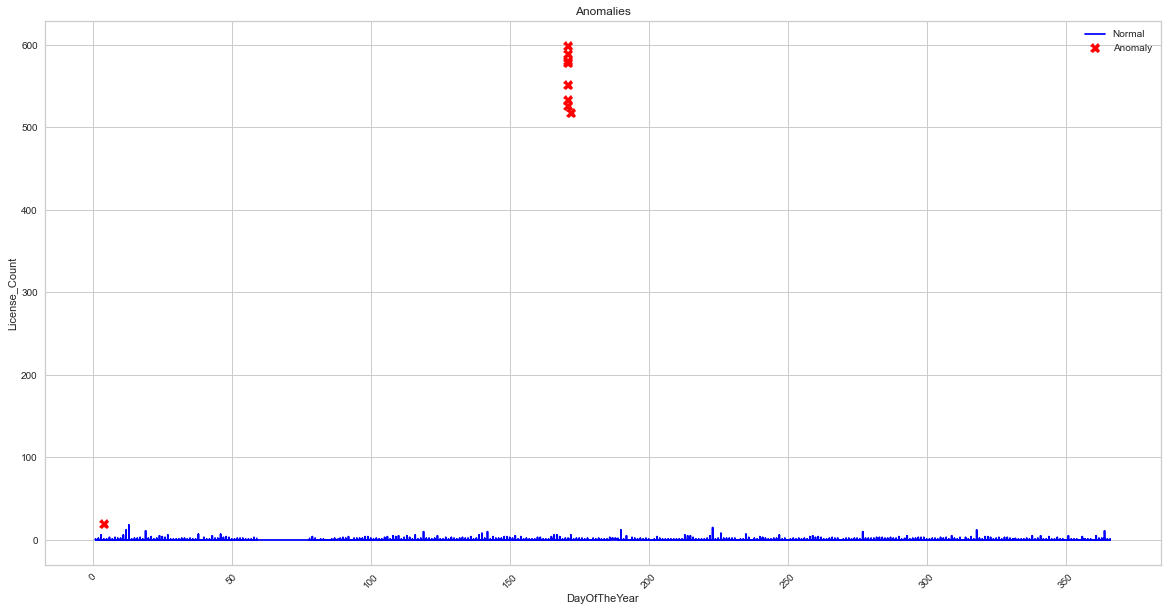

In [108]:
a = df_if[df_if['iforest'] == 1] #anomaly
n = df_if[df_if['iforest'] == 0] #normality
_ = plt.figure(figsize=(20,10))
_ = plt.plot(n['DayOfTheYear'],n['License_Count'], color='blue',markersize=5, label='Normal')
_ = plt.plot(a['DayOfTheYear'], a['License_Count'], linestyle='None', marker='X', color='red', markersize=10, label='Anomaly')
_ = plt.xlabel('DayOfTheYear')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

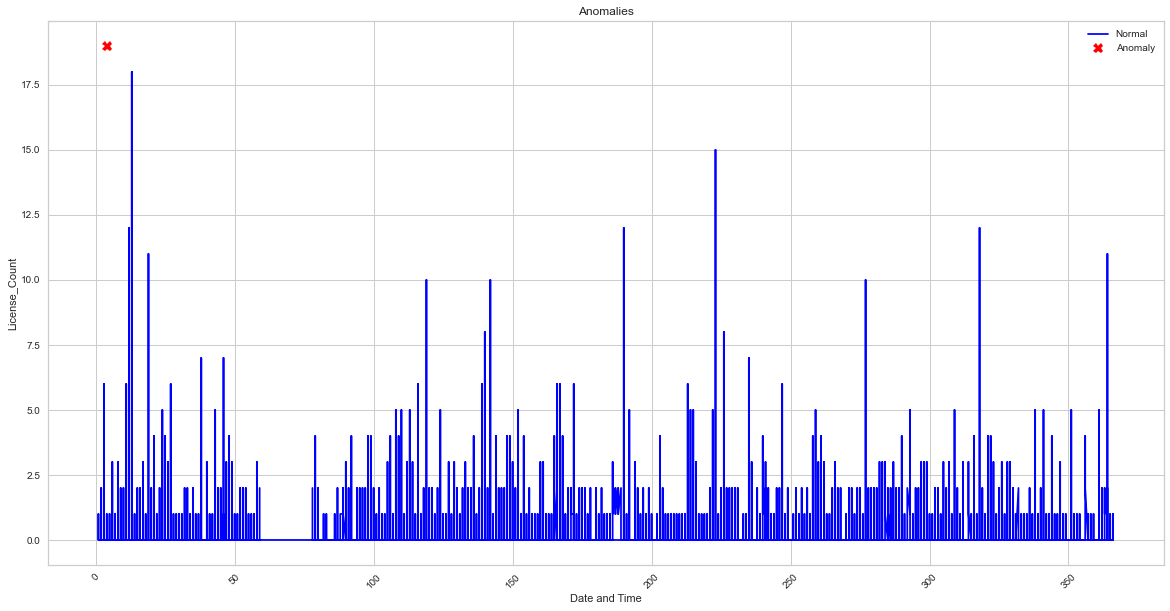

In [109]:
plottie = df_if[df_if['License_Count'] < 100]
a = plottie[plottie['iforest'] == 1] #anomaly
n = plottie[plottie['iforest'] == 0] #normality
_ = plt.figure(figsize=(20,10))
_ = plt.plot(n['DayOfTheYear'],n['License_Count'], color='blue',markersize=5, label='Normal')
_ = plt.plot(a['DayOfTheYear'], a['License_Count'], linestyle='None', marker='X', color='red', markersize=10, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('License_Count')
_ = plt.title('Anomalies')
_ = plt.legend(loc='best')
_ = plt.xticks(rotation=45)
plt.show();

#### Anomaly types based on Control team's descriptons

##### Too many licenses used

In [110]:
df_if[df_if['iforest'] == 1].sort_values(by='License_Count', ascending=False)

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,iforest
2245,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2246,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2244,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2247,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2248,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
2249,12,533,8,1,6,25,4,171,22,1,44.416667,533.0,0.083333,1
2250,12,526,8,1,6,25,4,171,23,1,43.833333,526.0,0.083333,1
2251,12,517,8,1,6,25,5,172,0,1,43.083333,517.0,0.083333,1
7017,6,19,1,1,1,1,0,4,14,1,3.166667,19.0,0.166667,1


##### Credentialsharing

###### Too much device

In [111]:
df_if[df_if['iforest'] == 1].sort_values(by='Num_Unique_DeviceIDs', ascending=False)[:20]

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,iforest
2244,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2245,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2246,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2247,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2248,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
2249,12,533,8,1,6,25,4,171,22,1,44.416667,533.0,0.083333,1
2250,12,526,8,1,6,25,4,171,23,1,43.833333,526.0,0.083333,1
2251,12,517,8,1,6,25,5,172,0,1,43.083333,517.0,0.083333,1
7017,6,19,1,1,1,1,0,4,14,1,3.166667,19.0,0.166667,1


###### Too many content

In [112]:
df_if[df_if['iforest'] == 1].sort_values(by='Num_Unique_ContentIDs', ascending=False)[:20]

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,iforest
2244,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2245,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2246,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2247,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2248,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
2249,12,533,8,1,6,25,4,171,22,1,44.416667,533.0,0.083333,1
2250,12,526,8,1,6,25,4,171,23,1,43.833333,526.0,0.083333,1
2251,12,517,8,1,6,25,5,172,0,1,43.083333,517.0,0.083333,1
7017,6,19,1,1,1,1,0,4,14,1,3.166667,19.0,0.166667,1


##### Sessionsharing

###### Too many IP addresses

In [113]:
df_if[df_if['iforest'] == 1].sort_values(by='Num_Unique_IPs', ascending=False)[:20]

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,iforest
2248,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
2249,12,533,8,1,6,25,4,171,22,1,44.416667,533.0,0.083333,1
2250,12,526,8,1,6,25,4,171,23,1,43.833333,526.0,0.083333,1
2251,12,517,8,1,6,25,5,172,0,1,43.083333,517.0,0.083333,1
2244,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2245,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2246,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2247,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
7017,6,19,1,1,1,1,0,4,14,1,3.166667,19.0,0.166667,1


#### Understanding the output

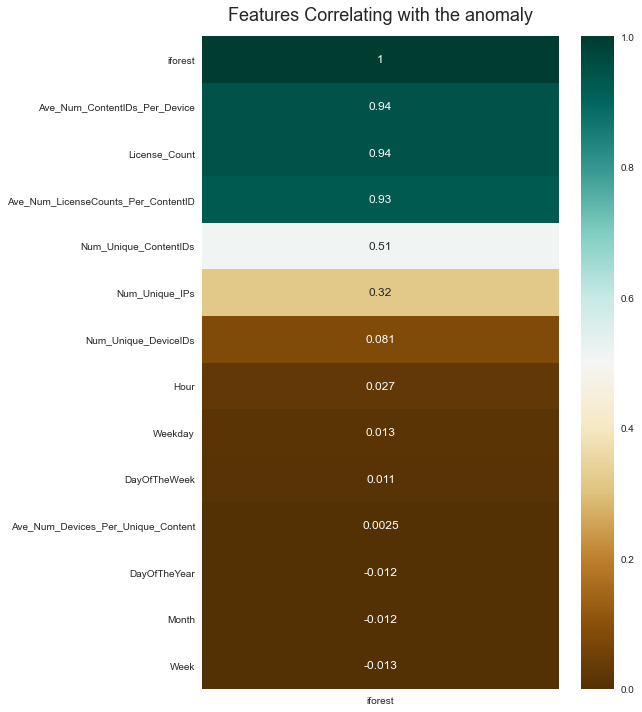

In [114]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_if.corr()[['iforest']].sort_values(by='iforest', ascending=False), vmin=0, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the anomaly', fontdict={'fontsize':18}, pad=16);

In [115]:
anomaly = df_if[df_if['iforest'] == 1]
anomaly.sort_values(by='Num_Unique_ContentIDs', ascending=False)

,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content,iforest
2244,12,580,1,1,6,25,4,171,17,1,48.333333,580.0,0.083333,1
2245,12,599,1,1,6,25,4,171,18,1,49.916667,599.0,0.083333,1
2246,12,589,1,1,6,25,4,171,19,1,49.083333,589.0,0.083333,1
2247,12,578,1,1,6,25,4,171,20,1,48.166667,578.0,0.083333,1
2248,12,552,8,1,6,25,4,171,21,1,46.000000,552.0,0.083333,1
2249,12,533,8,1,6,25,4,171,22,1,44.416667,533.0,0.083333,1
2250,12,526,8,1,6,25,4,171,23,1,43.833333,526.0,0.083333,1
2251,12,517,8,1,6,25,5,172,0,1,43.083333,517.0,0.083333,1
7017,6,19,1,1,1,1,0,4,14,1,3.166667,19.0,0.166667,1


#### Evaluation

In [116]:
df_if.to_csv('Isolation_Forest_output.csv',header=True)